In [1]:
import pandas as pd 
import spacy

In [2]:
phab_path = "/mmfs1/gscratch/comdata/users/mjilg/mw-repo-lifecycles/case2/041325_coref_rel_phab_comments.csv"
phab_df = pd.read_csv(phab_path)

In [3]:
def http_relevant(text):
    if pd.isnull(text):
        return False
    # expanded dictionary for relevancy
    # http, login, SSL, TLS, certificate 
    for word in text.split():
        if "://" not in word.lower():
            #http
            if "http" in word.lower():
                return True
            #login
            if "login" in word.lower():
                return True
            #ssl
            if "ssl" in word.lower():
                return True
            #tls
            if "tls" in word.lower():
                return True
            #cert
            if word.lower().startswith("cert"):
                return True
    return False

In [4]:
def is_migrated(comment_text):
    if pd.isnull(comment_text):
        return False
    text = comment_text.strip()
    if text.startswith("Originally from: http://sourceforge.net"):
        return True 
    return False

In [5]:
#find gerrit phab PHID: PHID-USER-idceizaw6elwiwm5xshb
#phab_df['isGerrit'] = phab_df['AuthorPHID'] == 'PHID-USER-idceizaw6elwiwm5xshb'

#cleaning df
#phab_df['id'] = phab_df.index + 1
#may have to build out the reply_to column 
#phab_df['reply_to'] = phab_df.groupby('TaskPHID')['id'].shift()
#phab_df['reply_to'] = phab_df['reply_to'].where(pd.notnull(phab_df['reply_to']), None)

#phab_df = phab_df.rename(columns={
#    'AuthorPHID': 'speaker',
#    'TaskPHID': 'conversation_id',
#    'WMFaffil':'meta.affil',
#    'isGerrit': 'meta.gerrit'
#})

# after 12-1-2012 before 12-1-2013
phab_df['timestamp'] = pd.to_datetime(phab_df['date_created'], unit='s', origin='unix', utc=True)
#filtered_phab_df = phab_df[(phab_df['date_created'] < 1385856000) & (phab_df['date_created'] > 1354320000)]
#filtered_phab_df = phab_df[(phab_df['date_created'] < 1381691276) & (phab_df['date_created'] > 1379975444)]

#removing headless conversations
task_phab_df = phab_df[phab_df['comment_type']=="task_description"]
headed_task_phids = task_phab_df['conversation_id'].unique()
filtered_phab_df = phab_df[phab_df['conversation_id'].isin(headed_task_phids)]

#removing gerrit comments 
#mid_comment_phab_df = filtered_phab_df[filtered_phab_df['meta.gerrit'] != True]

'''
# filter out the sourceforge migration 
# Originally from: http://sourceforge.net in the task task_summary
migrated_conversation_ids = task_phab_df[task_phab_df['comment_text'].apply(is_migrated)]['conversation_id'].unique()

#cut down to only the data that is relevant (mentions http)
relevant_conversation_ids = task_phab_df[
    task_phab_df['comment_text'].apply(http_relevant) |
    task_phab_df['task_title'].apply(http_relevant)
]['conversation_id'].unique()

task_phab_df['is_relevant'] = task_phab_df['conversation_id'].isin(relevant_conversation_ids)
mid_comment_phab_df['is_relevant'] = mid_comment_phab_df['conversation_id'].isin(relevant_conversation_ids)

task_phab_df['is_migrated'] = task_phab_df['conversation_id'].isin(migrated_conversation_ids)
mid_comment_phab_df['is_migrated'] = mid_comment_phab_df['conversation_id'].isin(migrated_conversation_ids)
'''
#comment_phab_df = mid_comment_phab_df[(mid_comment_phab_df['is_relevant'] == True) & (mid_comment_phab_df['is_migrated'] != True)]
#task_phab_df = task_phab_df[(task_phab_df['is_relevant'] == True) & (task_phab_df['is_migrated'] != True)]
comment_phab_df = filtered_phab_df

In [6]:
unique_conversation_ids = len(comment_phab_df['conversation_id'].unique())
unique_ids = len(comment_phab_df['id'].unique())
unique_speakers = len(comment_phab_df['speaker'].unique())

print(f"Unique conversation_ids: {unique_conversation_ids}")
print(f"Unique ids: {unique_ids}")
print(f"Unique speakers: {unique_speakers}")

Unique conversation_ids: 382
Unique ids: 1838
Unique speakers: 189


In [7]:
import re

def preprocess_text(text):
    text = str(text)
    text = text.replace('*', ' ')
    text = text.replace('-', ' ')
    text = re.sub(r'http\S+', '', text)
    return text

In [8]:
comment_phab_df['processed_text'] = comment_phab_df['comment_text'].apply(preprocess_text)

In [9]:
comment_phab_df['processed_resolved_text'] = comment_phab_df['resolved_text'].apply(preprocess_text)

In [10]:
nlp = spacy.load("en_core_web_sm")

def extract_dependency_tree(text):
    doc = nlp(text)
    dependency_trees = []
    
    for sentence in doc.sents:
        for token in sentence:
            token_info = (
                token.text, 
                token.lemma_, 
                token.dep_, 
                token.head.text, 
                list(token.ancestors), 
                list(token.subtree), 
                list(token.children)
            )
            dependency_trees.append(token_info)
        
    return dependency_trees

In [11]:
comment_phab_df['dependency_tree'] = comment_phab_df['processed_text'].apply(extract_dependency_tree)

In [12]:
comment_phab_df['resolved_dependency_tree'] = comment_phab_df['processed_resolved_text'].apply(extract_dependency_tree)

In [13]:
#get VAD scores
import numpy as np
#https://saifmohammad.com/WebPages/nrc-vad.html
column_headings = ['Word', 'Valence', 'Arousal', 'Domination']
vad_lexicon = pd.read_csv('NRC-VAD-Lexicon.txt', delimiter='\t', header=None, names=column_headings)
vad_dict = vad_lexicon.set_index('Word').T.to_dict()

def vad_scoring(dependency_tree):
    valence = []
    arousal = []
    dominance = []
    for token, lemma, dep, head, ancestors, subtree, children in dependency_tree:
        if lemma in vad_dict:
            valence.append(vad_dict[lemma]['Valence'])
            arousal.append(vad_dict[lemma]['Arousal'])
            dominance.append(vad_dict[lemma]['Domination'])

    # Compute average scores across the comment
    avg_valence = np.mean(valence) if valence else 0
    avg_arousal = np.mean(arousal) if arousal else 0
    avg_dominance = np.mean(dominance) if dominance else 0

    return [avg_valence, avg_arousal, avg_dominance]

def dominance_prevail(dependency_tree):
    dominant_words = 0 
    for token, lemma, dep, head, ancestors, subtree, children in dependency_tree:
        if lemma in vad_dict:
            if vad_dict[lemma]['Domination'] >= 0.75:
                dominant_words += 1
            if vad_dict[lemma]['Domination'] <= 0.25:
                dominant_words += 1
    return dominant_words

def arousal_prevail(dependency_tree):
    arousal_words = 0 
    for token, lemma, dep, head, ancestors, subtree, children in dependency_tree:
        if lemma in vad_dict:
            if vad_dict[lemma]['Arousal'] >= 0.75:
                arousal_words += 1
            if vad_dict[lemma]['Arousal'] <= 0.25:
                arousal_words += 1
    return arousal_words

def valence_prevail(dependency_tree):
    valence_words = 0 
    for token, lemma, dep, head, ancestors, subtree, children in dependency_tree:
        if lemma in vad_dict:
            if vad_dict[lemma]['Valence'] >= 0.75:
                valence_words += 1
            if vad_dict[lemma]['Valence'] <= 0.25:
                valence_words += 1
    return valence_words
    

In [14]:
#establishing per-comment VAD scores 
comment_phab_df['avg_vad_scores'] = comment_phab_df['dependency_tree'].apply(vad_scoring)
comment_phab_df['dominant_wc'] = comment_phab_df['dependency_tree'].apply(dominance_prevail)
comment_phab_df['arousal_wc'] = comment_phab_df['dependency_tree'].apply(arousal_prevail)
comment_phab_df['valence_wc'] = comment_phab_df['dependency_tree'].apply(valence_prevail)

In [15]:
comment_phab_df[['average_v_score', 'average_a_score', 'average_d_score']] = pd.DataFrame(comment_phab_df['avg_vad_scores'].tolist(), index=comment_phab_df.index)
comment_phab_df = comment_phab_df.drop(columns=['avg_vad_scores'])

In [16]:
def token_http_relevant(word):
    # expanded dictionary for relevancy
    # http, login, SSL, TLS, certificate 
    if "://" not in word.lower():
        #http
        if "http" in word.lower():
            return True
        #login
        if "login" in word.lower():
            return True
        #ssl
        if "ssl" in word.lower():
            return True
        #tls
        if "tls" in word.lower():
            return True
        #cert
        if word.lower().startswith("cert"):
            return True
    return False

In [24]:
import datetime

In [17]:
# expand the dependency parser 

#pattern = r'\b(ve|VE|visualeditor|VisualEditor)\b'
#pattern = r'\b(WMF|Foundation)\b'
#pattern = r'\b(bots|scripts|gadgets)\b'
pattern = r'\b(http|https)\b'

dependency_relations = []
resolved_dependency_relations = []

for index, row in comment_phab_df.iterrows():
    text = row['comment_text']
    timestamp = row['timestamp']
    comment_id = row['id']
    conversation_id = row['conversation_id']
    WMFaffil = row['meta.affil']
    
    for token, lemma, dep, head, ancestors, subtree, children in row['dependency_tree']:
        if token_http_relevant(token):
            dependency_relations.append({
                'comment_id': comment_id,
                'timestamp': timestamp,
                'wmfAffil':WMFaffil,
                'token': token,
                'dependency': dep,
                'head': head,
                'depth': len(list(ancestors)), 
                'children': len(list(children)) 
            })
   
    for token, lemma, dep, head, ancestors, subtree, children in row['resolved_dependency_tree']:
        if token_http_relevant(token):
            resolved_dependency_relations.append({
                'comment_id': comment_id,
                'timestamp': timestamp,
                'wmfAffil':WMFaffil,
                'token': token,
                'dependency': dep,
                'head': head,
                'depth': len(list(ancestors)), 
                'children': len(list(children)) 
            })

resolved_dependency_relations_df = pd.DataFrame(resolved_dependency_relations)            
dependency_relations_df = pd.DataFrame(dependency_relations)

In [19]:
#now analysis/plotting 
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.gridspec import GridSpec

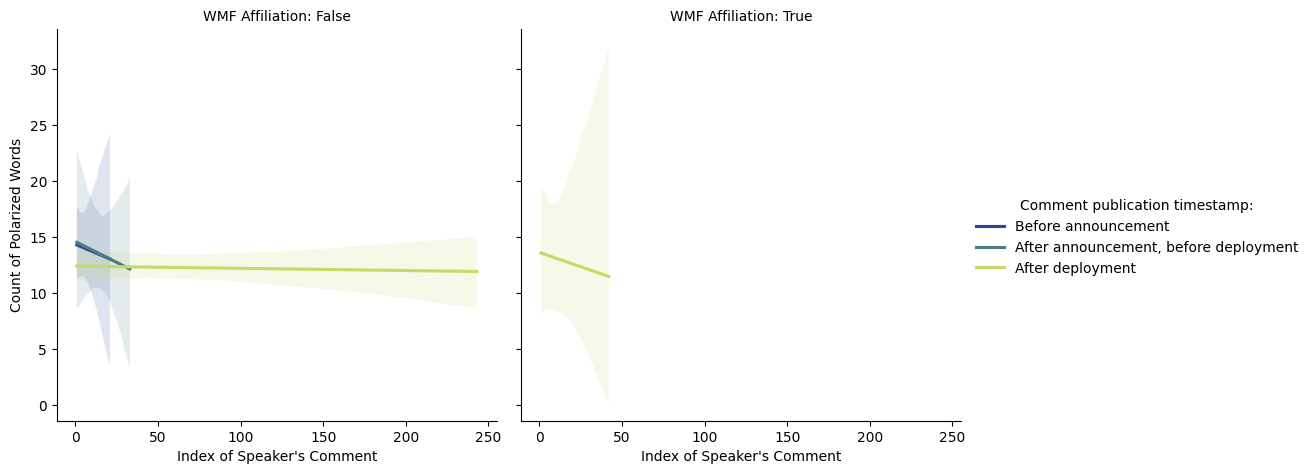

In [35]:
plot2 = sns.lmplot(data=affective_comment_phab_df, x="speakers_comment", y="polarized_wc", hue="date_group", col="meta.affil", scatter=False, legend=False, palette=palette)
plot2.set_axis_labels("Index of Speaker's Comment", "Count of Polarized Words")
plot2.set_titles(col_template="WMF Affiliation: {col_name}")
plot2.fig.subplots_adjust(top=0.9)  # Adjust subplots to make room for the title
plot2.add_legend(title="Comment publication timestamp:")

In [21]:
resolved_dependency_relations_df

comment_id                 timestamp  wmfAffil          token  \
0            115 2013-10-11 09:04:00+00:00     False  use_api_login   
1            157 2013-10-07 08:09:00+00:00     False  use_api_login   
2            177 2013-10-04 17:56:00+00:00     False      certainly   
3            247 2013-09-27 22:15:00+00:00     False          Login   
4            426 2013-09-01 11:26:00+00:00     False           HTTP   
...          ...                       ...       ...            ...   
1463       45300 2013-08-01 17:35:00+00:00     False        certain   
1464       45300 2013-08-01 17:35:00+00:00     False        certain   
1465       45373 2013-07-27 13:30:00+00:00     False        certain   
1466       46078 2013-06-18 21:17:00+00:00     False           HTTP   
1467       46086 2013-06-19 23:31:02+00:00     False           HTTP   

     dependency      head  depth  children  
0          dobj   use_api      1         6  
1          dobj   use_api      1         4  
2        advmod   require      2         1  
3          ROOT     Login      0         4  
4      compound     login      4         0  
...         ...       ...    ...       ...  
1463       amod  commands      5         0  
1464       amod  commands      5         0  
1465       amod   element      8         0  
1466   compound     Error      2         0  
1467   compound     Error      3         0  

[1468 rows x 8 columns]

/tmp/ipykernel_79236/963914566.py:4: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  filtered_dependencies = dependency_relations_df[dependency_relations_df['token'].str.contains(pattern, regex=True)]
/tmp/ipykernel_79236/963914566.py:5: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  resolved_filtered_dependencies = resolved_dependency_relations_df[resolved_dependency_relations_df['token'].str.contains(pattern, regex=True)]
/tmp/ipykernel_79236/963914566.py:20: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  filtered_dependencies['week'] = filtered_dependencies['timestamp'].dt.to_period('W').dt.start_time
/tmp/ipykernel_79236/963914566.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_index

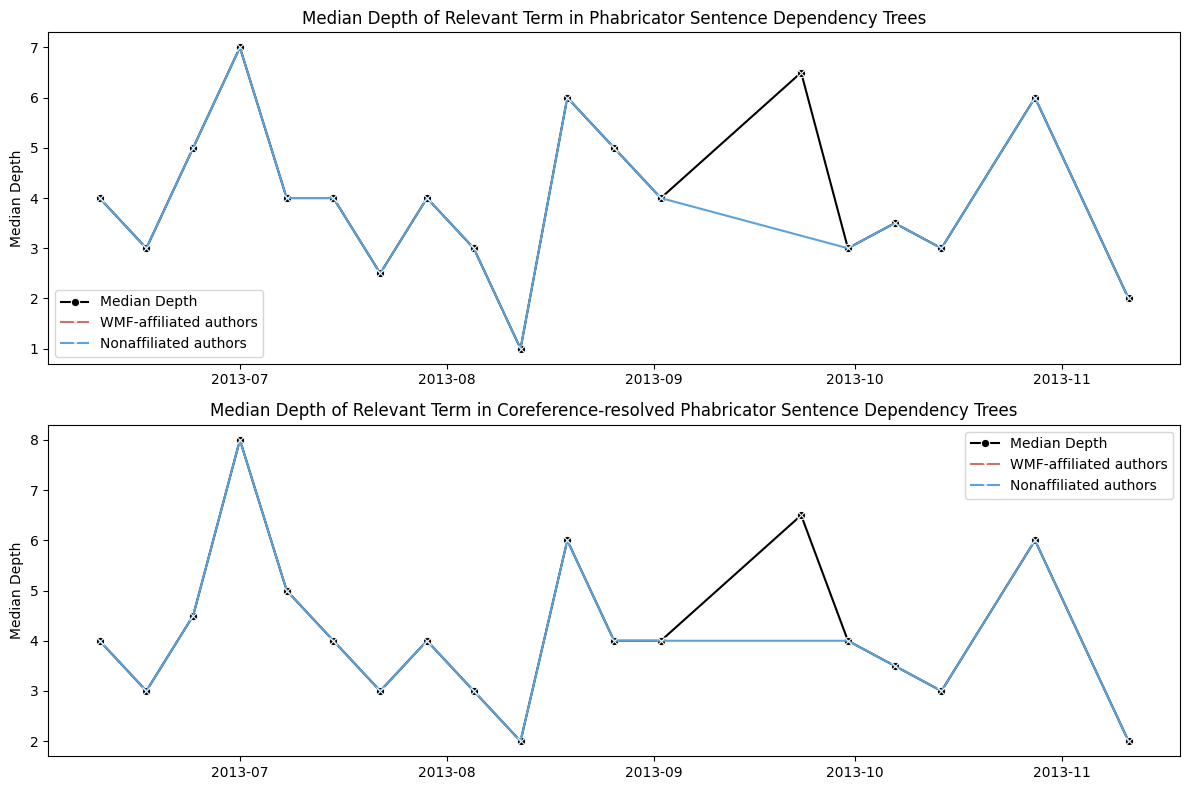

In [22]:
#pattern = r'\b(ve|VE|visualeditor|VisualEditor)\b'
#pattern = r'\b(WMF|Foundation)\b'
#pattern = r'\b(bots)\b'
filtered_dependencies = dependency_relations_df[dependency_relations_df['token'].str.contains(pattern, regex=True)]
resolved_filtered_dependencies = resolved_dependency_relations_df[resolved_dependency_relations_df['token'].str.contains(pattern, regex=True)]

plt.figure(figsize=(12, 8))
gs = GridSpec(2, 1, height_ratios=[6, 6])

# Main plot: Token depth by timestamp
'''
ax0 = plt.subplot(gs[0])
sns.scatterplot(data=filtered_dependencies, x='timestamp', y='dependency', hue='wmfAffil', style='dependency', markers=True, s=100, ax=ax0)
ax0.set_title('VE Depth by Timestamp w/o URLS')
ax0.set_xlabel('')
ax0.set_ylabel('Dependency Type')
ax0.legend().set_visible(False)
'''
# Calculate the median depth over time
filtered_dependencies['week'] = filtered_dependencies['timestamp'].dt.to_period('W').dt.start_time
median_depth = filtered_dependencies.groupby('week')['depth'].median().reset_index()

wmf_filtered_dependencies = filtered_dependencies[filtered_dependencies['wmfAffil'] == True]
wmf_median_depth = wmf_filtered_dependencies.groupby('week')['depth'].median().reset_index()

other_filtered_dependencies = filtered_dependencies[filtered_dependencies['wmfAffil'] != True]
other_median_depth = other_filtered_dependencies.groupby('week')['depth'].median().reset_index()

# Plot the median depth over time
ax0 = plt.subplot(gs[0])
sns.lineplot(data=median_depth, x='week', y='depth', ax=ax0, color='black', label='Median Depth', marker='o')
sns.lineplot(data=wmf_median_depth, x='week', y='depth', ax=ax0, color='#c7756a', label='WMF-affiliated authors', marker='x')
sns.lineplot(data=other_median_depth, x='week', y='depth', ax=ax0, color='#5da2d8', label='Nonaffiliated authors', marker='x')
ax0.set_title('Median Depth of Relevant Term in Phabricator Sentence Dependency Trees')
ax0.set_ylabel('Median Depth')
ax0.set_xlabel('')

# Calculate the median depth over time
resolved_filtered_dependencies['week'] = resolved_filtered_dependencies['timestamp'].dt.to_period('W').dt.start_time
resolved_median_depth = resolved_filtered_dependencies.groupby('week')['depth'].median().reset_index()

resolved_wmf_filtered_dependencies = resolved_filtered_dependencies[resolved_filtered_dependencies['wmfAffil'] == True]
resolved_wmf_median_depth = resolved_wmf_filtered_dependencies.groupby('week')['depth'].median().reset_index()

resolved_other_filtered_dependencies = resolved_filtered_dependencies[resolved_filtered_dependencies['wmfAffil'] != True]
resolved_other_median_depth = resolved_other_filtered_dependencies.groupby('week')['depth'].median().reset_index()

# Plot the median depth over time
ax1 = plt.subplot(gs[1])
sns.lineplot(data=resolved_median_depth, x='week', y='depth', ax=ax1, color='black', label='Median Depth', marker='o')
sns.lineplot(data=resolved_wmf_median_depth, x='week', y='depth', ax=ax1, color='#c7756a', label='WMF-affiliated authors', marker='x')
sns.lineplot(data=resolved_other_median_depth, x='week', y='depth', ax=ax1, color='#5da2d8', label='Nonaffiliated authors', marker='x')
ax1.set_title('Median Depth of Relevant Term in Coreference-resolved Phabricator Sentence Dependency Trees')
ax1.set_ylabel('Median Depth')
ax1.set_xlabel('')

plt.tight_layout()
#plt.show()

#plt.savefig('031625_VE_depth_fig.png')